# LOAD LIBS

In [2]:
import sys
import os

In [3]:
project_root = '/nas.dbms/rzhb/repos/tscil-ext'
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [4]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [5]:
color_palette = {
    0: "tab:red",
    1: "tab:blue",
    2: "tab:green",
    3: "tab:cyan",
    4: "tab:pink",
    5: "tab:gray",
    6: "tab:orange",
    7: "tab:brown",
    8: "tab:olive",
    9: "tab:purple",
    10: "darkseagreen",
    11: "black",
}

# Load Data

In [6]:
from data.grabmyo import window_len_grabmyo, input_channels_grabmyo
from data.wisdm import window_len_wisdm


input_size_match = {
    "har": [128, 9],
    "uwave": [315, 3],
    "dailysports": [125, 45],
    "grabmyo": [window_len_grabmyo, input_channels_grabmyo],
    "wisdm": [window_len_wisdm, 3],
}
content_root = os.path.abspath(".")
data_path = {
    "har": content_root + "/data/saved/HAR_inertial/",
    "uwave": content_root + "/data/saved/UWave/",
    "dailysports": content_root + "/data/saved/DailySports/",
    "grabmyo": content_root + "/data/saved/GRABMyo/",
    "wisdm": content_root + "/data/saved/WISDM/",
}

In [7]:
from utils.stream import IncrementalTaskStream, get_cls_order
from utils.utils import seed_fixer


seed = 1234
run = 0
data = 'dailysports'
fix_order = False
stream_split = 'exp'
scenario = 'class'

seed_fixer(seed + run)
cls_order = get_cls_order(data, fix_order)
print(
        "\n ######## {} tasks, Run {}, cls_order :{} ########".format(
            stream_split, run, cls_order
        )
    )
task_stream = IncrementalTaskStream(
    data=data,
    scenario=scenario,
    cls_order=cls_order,
    split=stream_split,
)
task_stream.path = data_path[data]
task_stream.setup()


 ######## exp tasks, Run 0, cls_order :[11, 3, 17, 10, 13, 14, 0, 2, 16, 7, 1, 9, 8, 4, 12, 5, 6, 15] ########
Create exp stream : 6 tasks,  classes order [0, 2, 16, 7, 1, 9, 8, 4, 12, 5, 6, 15] 
Input shape (L, D): (125, 45)
Training set size: 3888; Val set size: 432; Test set size: 1440


# Data Dist

In [ ]:
from utils.data import Dataloader_from_numpy, extract_samples_according_to_labels
data_t0 = task_stream.tasks[0]
(x_train_t0, y_train_t0), (x_val_t0, y_val_t0), (x_test_t0, y_test_t0) = data_t0
(x_train_c0, y_train_c0) = extract_samples_according_to_labels(x_train_t0, y_train_t0, [0])

# GGCPV2

In [8]:
from models.gcppVAE import GCVariationalAutoencoderConv
device = 'cuda'

In [ ]:
generator = GCVariationalAutoencoderConv(
    seq_len=input_size_match[data][0],
    feat_dim=input_size_match[data][1],
    latent_dim=128,  # 2 for visualization
    hidden_layer_sizes=[64, 128, 256, 512],  # [128, 256]
    device=device,
    recon_wt=0.1,
    )

# TSNE

## TSNE-D2

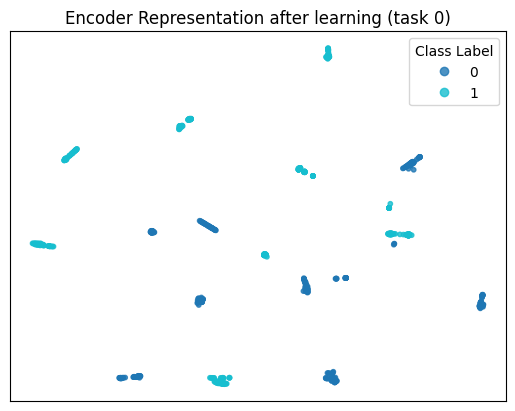

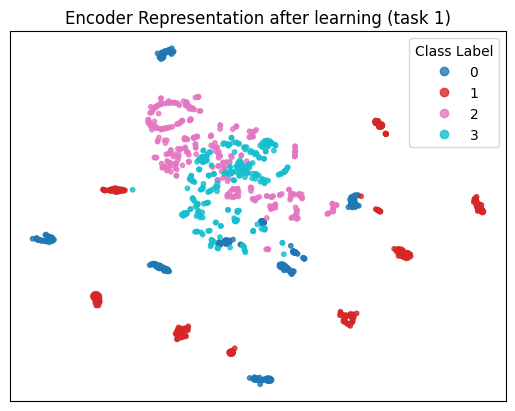

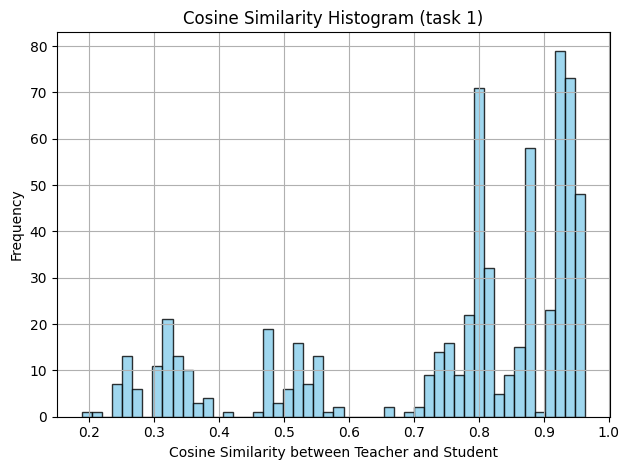

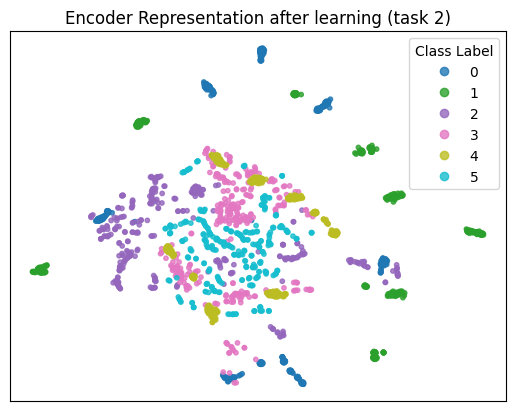

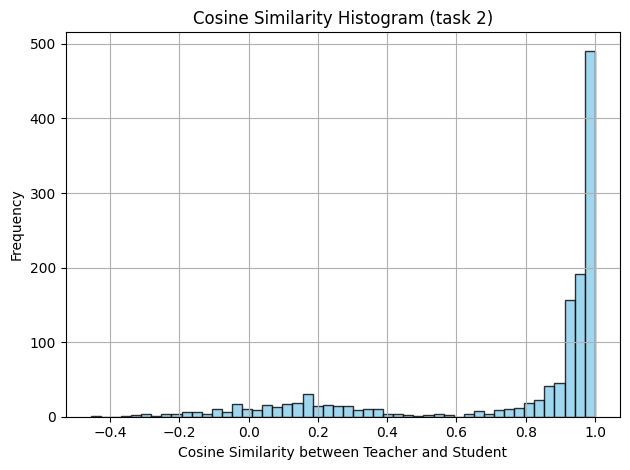

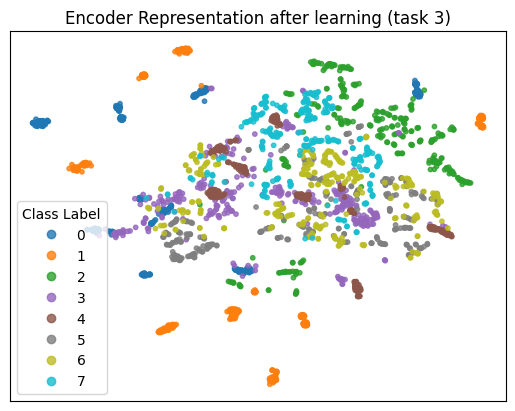

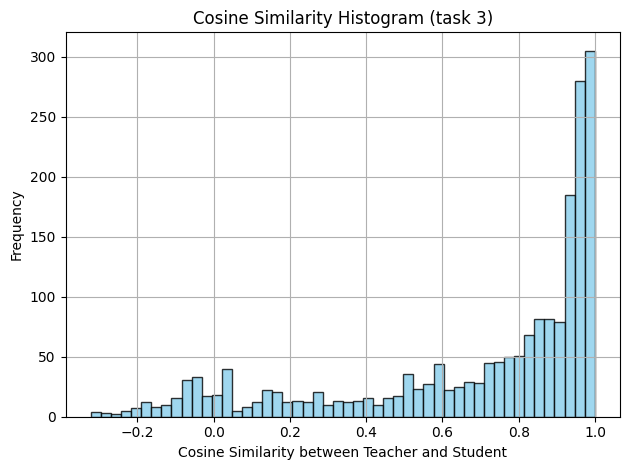

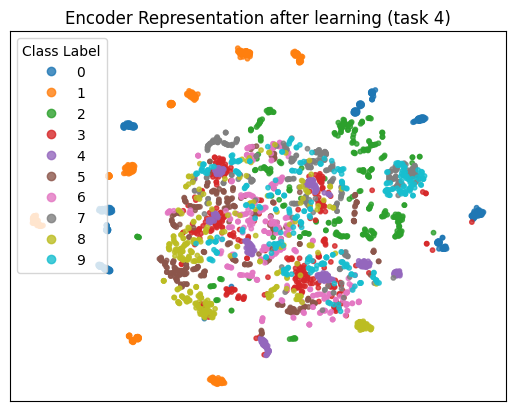

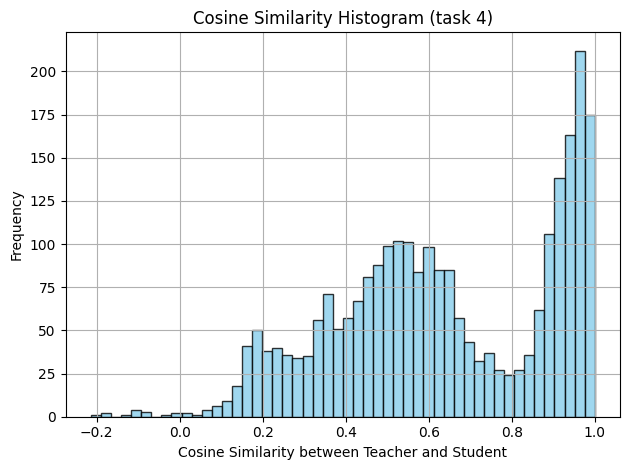

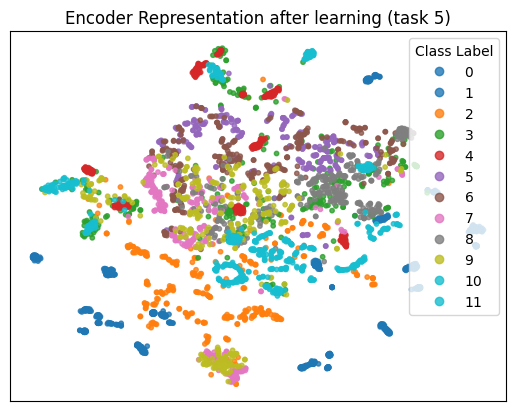

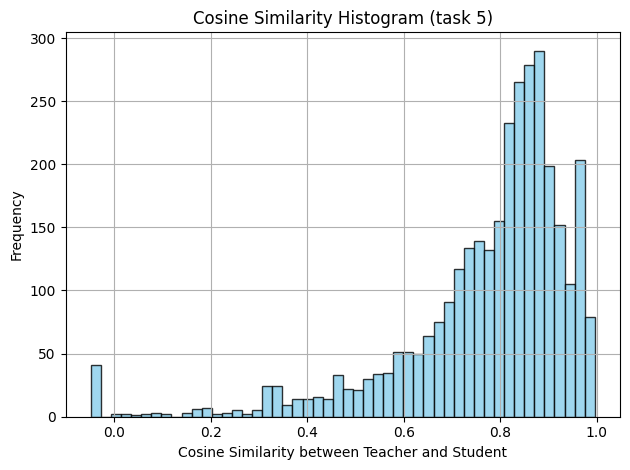

In [30]:
seed_fixer(seed + run)

x_tcurr, y_tcurr = None, None
x_tprev, y_tprev = None, None

for task in range(task_stream.n_tasks):
    (x_i, y_i), _, _ = task_stream.tasks[task]

    if task == 0:
        x_tcurr, y_tcurr = x_i, y_i
    else:
        x_tprev, y_tprev = x_tcurr.copy(), y_tcurr.copy()

        x_tcurr = np.concatenate((x_tcurr, x_i))
        y_tcurr = np.concatenate((y_tcurr, y_i))

    if x_tcurr is not None and y_tcurr is not None:
        x_tcurr_, y_tcurr_ = torch.Tensor(x_tcurr).to(device), torch.Tensor(y_tcurr).to(device)
    if x_tprev is not None and y_tprev is not None:
        x_tprev_, y_tprev_ = torch.Tensor(x_tprev).to(device), torch.Tensor(y_tprev).to(device)

    generator = GCVariationalAutoencoderConv(
        seq_len=input_size_match[data][0],
        feat_dim=input_size_match[data][1],
        latent_dim=128,  # 2 for visualization
        hidden_layer_sizes=[64, 128, 256, 512],  # [128, 256]
        device=device,
        fmap=True,
        recon_wt=0.1,
    )

    n_decoder_tcurr = 2*(task+1) 
    ckpt_tcurr = 2*task+1

    for id in range(n_decoder_tcurr):
        generator.create_decoder(id)

    if ckpt_tcurr != 0:
        generator.copy_encoder()

    checkpoint_path = os.getcwd() + f'/result/exp/debug/CNN_dailysports/GCPPv2_D2/generator_ckpt_{ckpt_tcurr}_r0.pt' 
    state_dict = torch.load(checkpoint_path, map_location='cuda')

    generator.load_state_dict(state_dict)

    z_mean_tcurr_, z_log_var_tcurr_, z_tcurr_ = generator.encoder(x_tcurr_.transpose(1, 2))
    features_tcurr = z_mean_tcurr_.cpu().detach().numpy()

    tsne_tcurr = TSNE(n_components=2)
    tsne_tc = tsne_tcurr.fit_transform(features_tcurr)

    # plt.figure(figsize=(8,6))
    scatter_tcurr = plt.scatter(tsne_tc[:, 0], tsne_tc[:, 1], c=y_tcurr, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter_tcurr.legend_elements(), title="Class Label")
    plt.title(f"Encoder Representation after learning (task {task})")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

    if task != 0:
        z_mean_teacher_, z_log_var_teacher_, z_teacher_ = generator.encoder_teacher(x_tprev_.transpose(1, 2))
        features_teacher = z_mean_teacher_.cpu().detach().numpy()

        tsne_teacher = TSNE(n_components=2)
        tsne_t = tsne_teacher.fit_transform(features_teacher)

        z_mean_student_, z_log_var_student_, z_student_ = generator.encoder(x_tprev_.transpose(1, 2))
        features_student = z_mean_student_.cpu().detach().numpy()

        tsne_student = TSNE(n_components=2)
        tsne_s = tsne_student.fit_transform(features_student)

        z_norm_teacher_ = F.normalize(z_mean_teacher_, dim=1)
        z_norm_student_ = F.normalize(z_mean_student_, dim=1)

        cos_sim = torch.sum(z_norm_teacher_ * z_norm_student_, dim=1)
        cos_sim_np = cos_sim.cpu().detach().numpy()

        plt.hist(cos_sim_np, bins=50, color='skyblue', edgecolor='black', alpha=0.8)
        plt.xlabel('Cosine Similarity between Teacher and Student')
        plt.ylabel('Frequency')
        plt.title(f'Cosine Similarity Histogram (task {task})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

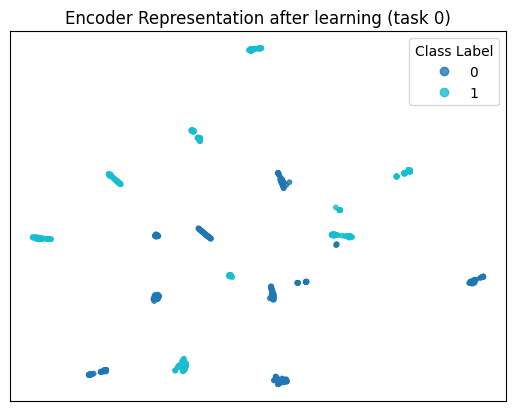

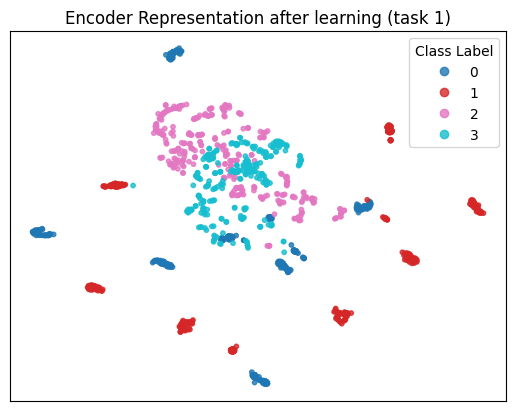

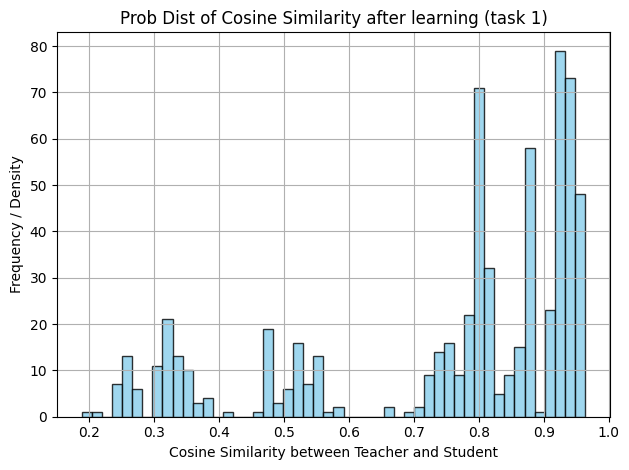

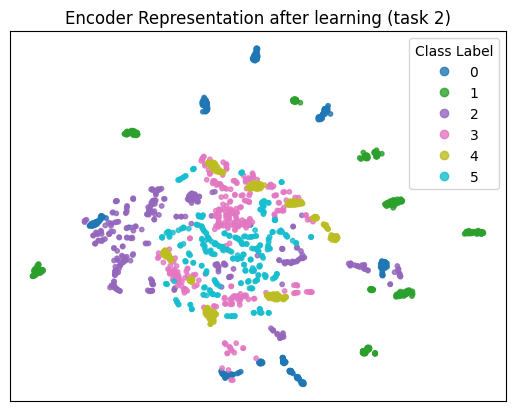

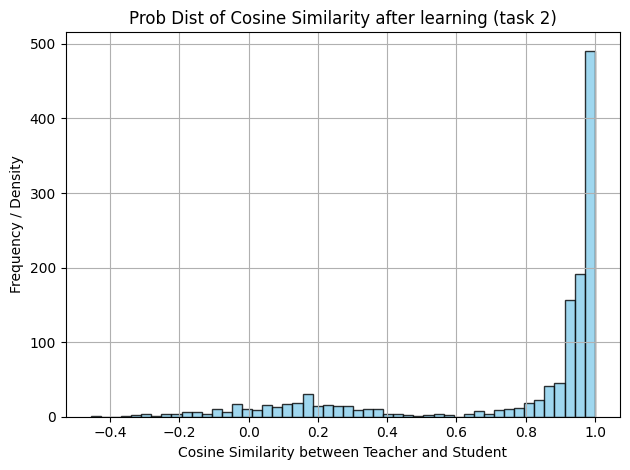

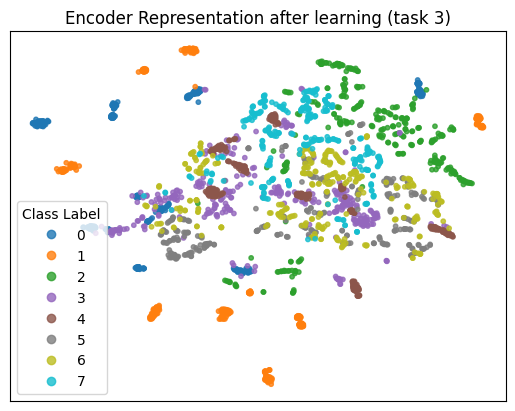

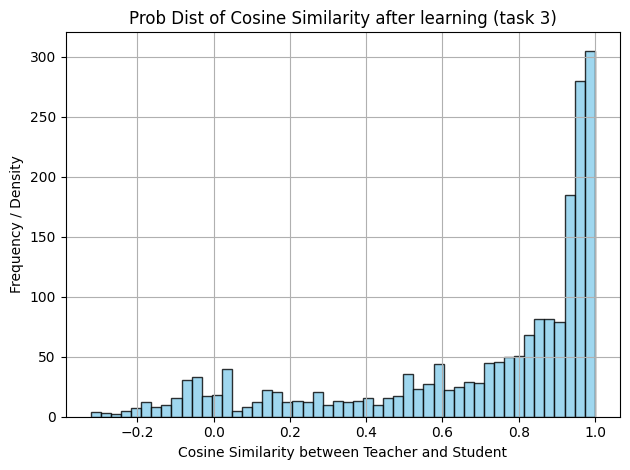

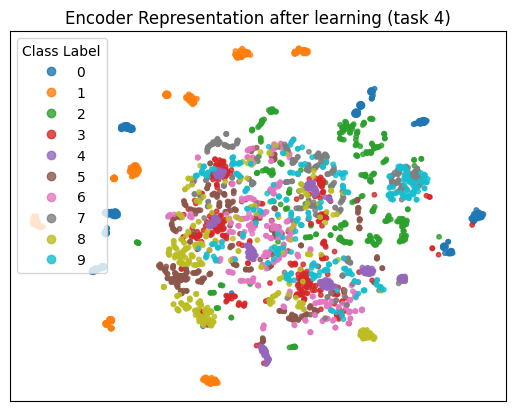

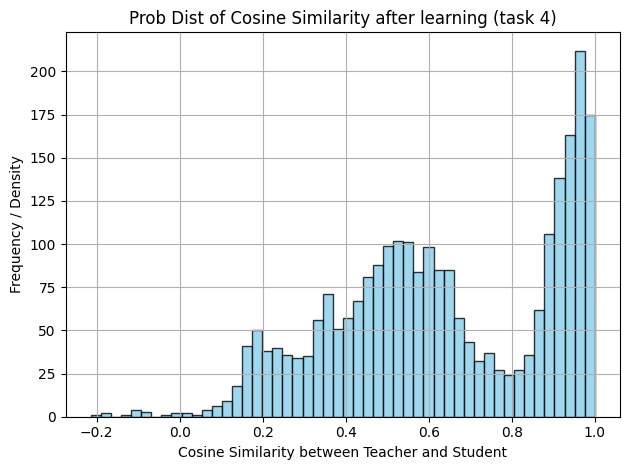

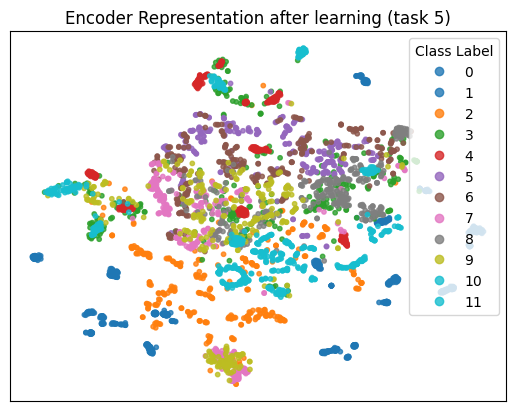

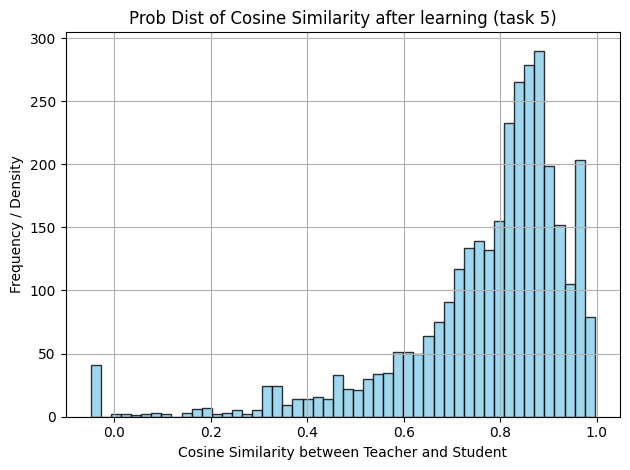

In [15]:
seed_fixer(seed + run)

x_tcurr, y_tcurr = None, None
x_tprev, y_tprev = None, None

for task in range(task_stream.n_tasks):
    (x_i, y_i), _, _ = task_stream.tasks[task]

    if task == 0:
        x_tcurr, y_tcurr = x_i, y_i
    else:
        x_tprev, y_tprev = x_tcurr.copy(), y_tcurr.copy()

        x_tcurr = np.concatenate((x_tcurr, x_i))
        y_tcurr = np.concatenate((y_tcurr, y_i))

    if x_tcurr is not None and y_tcurr is not None:
        x_tcurr_, y_tcurr_ = torch.Tensor(x_tcurr).to(device), torch.Tensor(y_tcurr).to(device)
    if x_tprev is not None and y_tprev is not None:
        x_tprev_, y_tprev_ = torch.Tensor(x_tprev).to(device), torch.Tensor(y_tprev).to(device)

    generator = GCVariationalAutoencoderConv(
        seq_len=input_size_match[data][0],
        feat_dim=input_size_match[data][1],
        latent_dim=128,  # 2 for visualization
        hidden_layer_sizes=[64, 128, 256, 512],  # [128, 256]
        device=device,
        fmap=True,
        recon_wt=0.1,
    )

    n_decoder_tcurr = 2*(task+1) 
    ckpt_tcurr = 2*task+1

    for id in range(n_decoder_tcurr):
        generator.create_decoder(id)

    if ckpt_tcurr != 0:
        generator.copy_encoder()

    checkpoint_path = os.getcwd() + f'/result/exp/debug/CNN_dailysports/GCPPv2_D2/generator_ckpt_{ckpt_tcurr}_r0.pt' 
    state_dict = torch.load(checkpoint_path, map_location='cuda')

    generator.load_state_dict(state_dict)

    z_mean_tcurr_, z_log_var_tcurr_, z_tcurr_ = generator.encoder(x_tcurr_.transpose(1, 2))
    features_tcurr = z_mean_tcurr_.cpu().detach().numpy()

    tsne_tcurr = TSNE(n_components=2)
    tsne_tc = tsne_tcurr.fit_transform(features_tcurr)

    # plt.figure(figsize=(8,6))
    scatter_tcurr = plt.scatter(tsne_tc[:, 0], tsne_tc[:, 1], c=y_tcurr, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter_tcurr.legend_elements(), title="Class Label")
    plt.title(f"Encoder Representation after learning (task {task})")
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    # plt.grid(False)
    plt.show()

    if task != 0:
        z_mean_teacher_, z_log_var_teacher_, z_teacher_ = generator.encoder_teacher(x_tprev_.transpose(1, 2))
        features_teacher = z_mean_teacher_.cpu().detach().numpy()

        tsne_teacher = TSNE(n_components=2)
        tsne_t = tsne_teacher.fit_transform(features_teacher)

        z_mean_student_, z_log_var_student_, z_student_ = generator.encoder(x_tprev_.transpose(1, 2))
        features_student = z_mean_student_.cpu().detach().numpy()

        tsne_student = TSNE(n_components=2)
        tsne_s = tsne_student.fit_transform(features_student)

        z_norm_teacher_ = F.normalize(z_mean_teacher_, dim=1)
        z_norm_student_ = F.normalize(z_mean_student_, dim=1)

        cos_sim = torch.sum(z_norm_teacher_ * z_norm_student_, dim=1)
        cos_sim_np = cos_sim.cpu().detach().numpy()

        plt.hist(cos_sim_np, bins=50, color='skyblue', edgecolor='black', alpha=0.8)
        plt.xlabel('Cosine Similarity between Teacher and Student')
        plt.ylabel('Frequency / Density')
        plt.title(f'Prob Dist of Cosine Similarity after learning (task {task})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## TSNE-C2

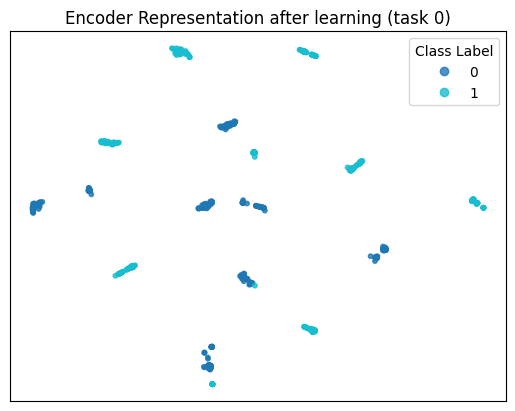

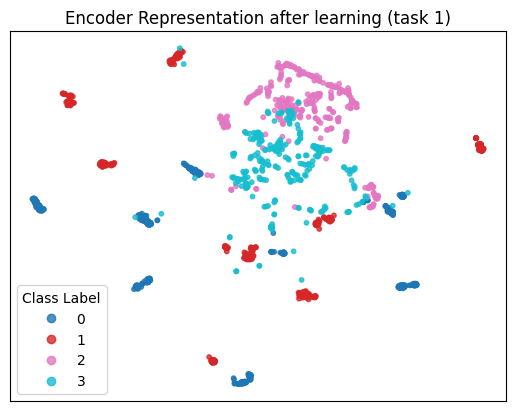

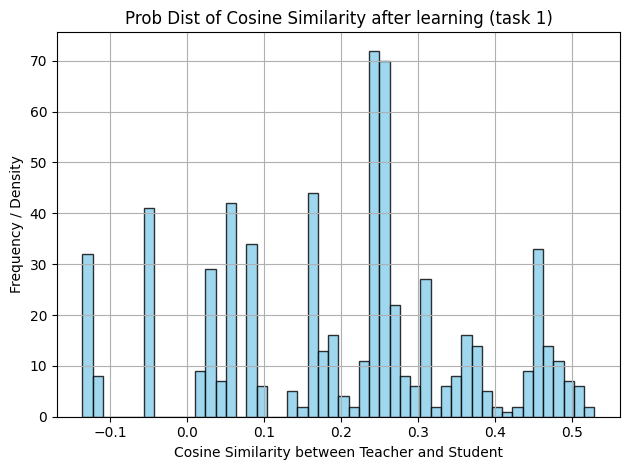

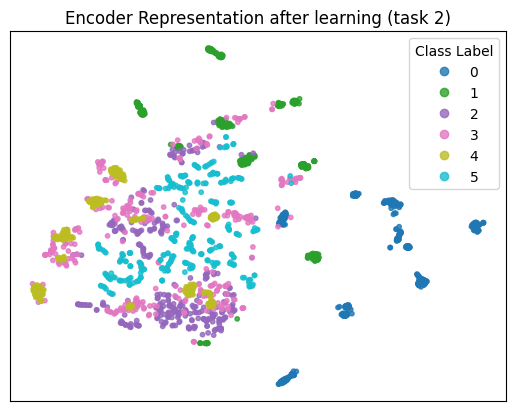

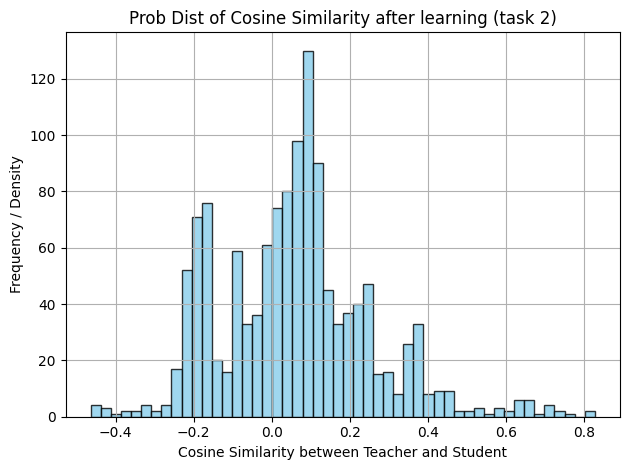

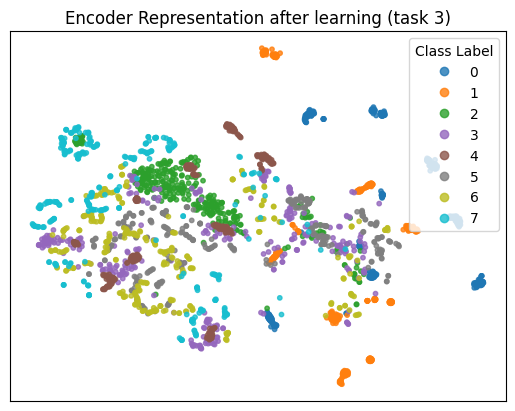

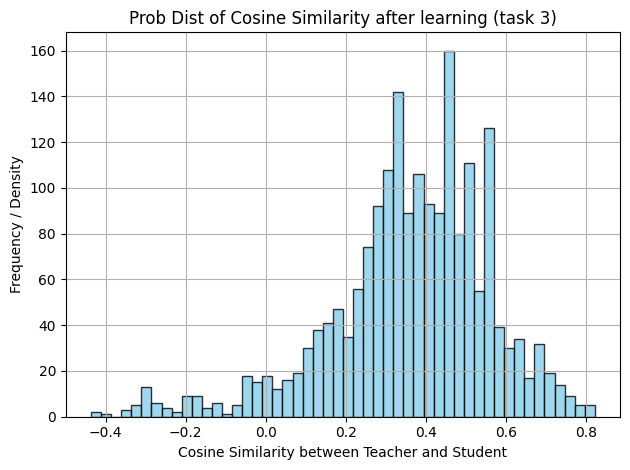

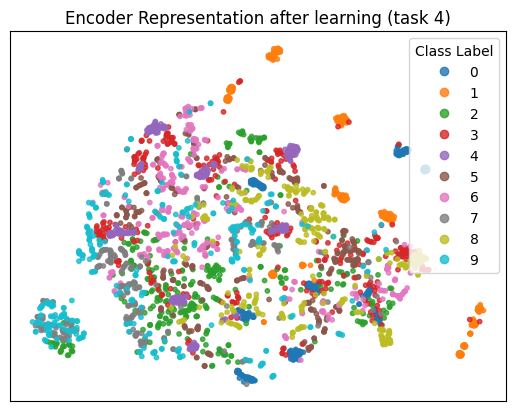

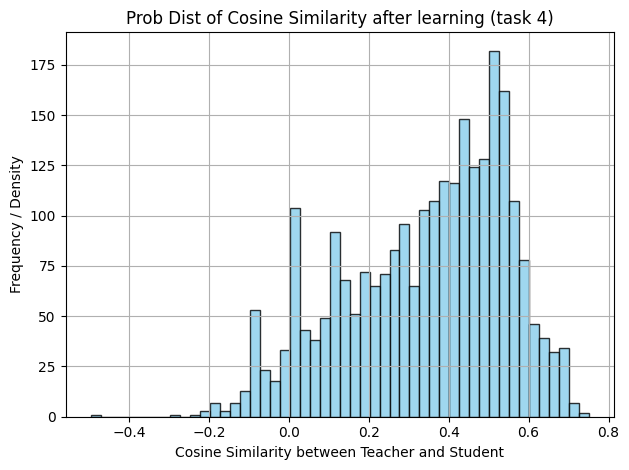

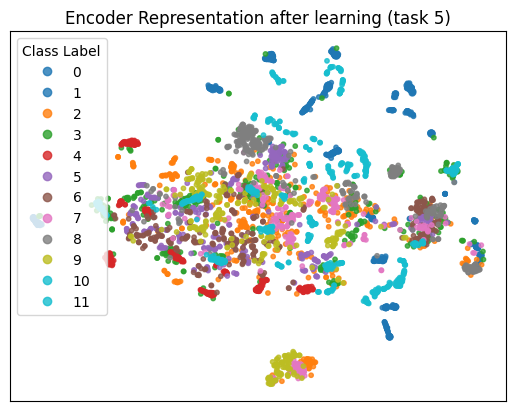

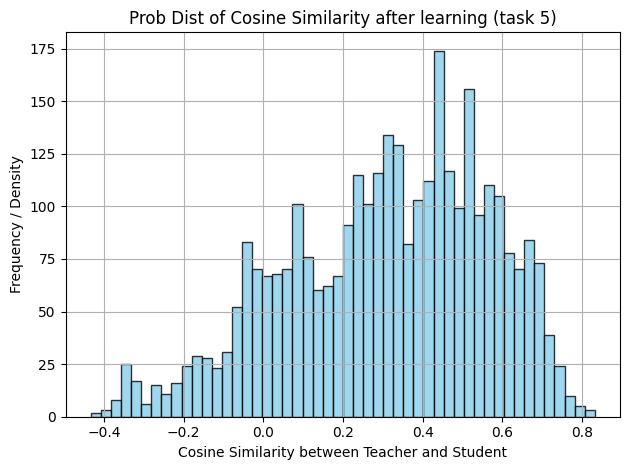

In [10]:
seed_fixer(seed + run)

x_tcurr, y_tcurr = None, None
x_tprev, y_tprev = None, None

for task in range(task_stream.n_tasks):
    (x_i, y_i), _, _ = task_stream.tasks[task]

    if task == 0:
        x_tcurr, y_tcurr = x_i, y_i
    else:
        x_tprev, y_tprev = x_tcurr.copy(), y_tcurr.copy()

        x_tcurr = np.concatenate((x_tcurr, x_i))
        y_tcurr = np.concatenate((y_tcurr, y_i))

    if x_tcurr is not None and y_tcurr is not None:
        x_tcurr_, y_tcurr_ = torch.Tensor(x_tcurr).to(device), torch.Tensor(y_tcurr).to(device)
    if x_tprev is not None and y_tprev is not None:
        x_tprev_, y_tprev_ = torch.Tensor(x_tprev).to(device), torch.Tensor(y_tprev).to(device)

    generator = GCVariationalAutoencoderConv(
        seq_len=input_size_match[data][0],
        feat_dim=input_size_match[data][1],
        latent_dim=128,  # 2 for visualization
        hidden_layer_sizes=[64, 128, 256, 512],  # [128, 256]
        device=device,
        fmap=True,
        recon_wt=0.1,
    )

    n_decoder_tcurr = 2*(task+1) 
    ckpt_tcurr = 2*task+1

    for id in range(n_decoder_tcurr):
        generator.create_decoder(id)

    if ckpt_tcurr != 0:
        generator.copy_encoder()

    checkpoint_path = os.getcwd() + f'/result/exp/debug/CNN_dailysports/GCPPv2_C2/generator_ckpt_{ckpt_tcurr}_r0.pt' 
    state_dict = torch.load(checkpoint_path, map_location='cuda')

    generator.load_state_dict(state_dict)

    z_mean_tcurr_, z_log_var_tcurr_, z_tcurr_ = generator.encoder(x_tcurr_.transpose(1, 2))
    features_tcurr = z_mean_tcurr_.cpu().detach().numpy()

    tsne_tcurr = TSNE(n_components=2)
    tsne_tc = tsne_tcurr.fit_transform(features_tcurr)

    # plt.figure(figsize=(8,6))
    scatter_tcurr = plt.scatter(tsne_tc[:, 0], tsne_tc[:, 1], c=y_tcurr, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter_tcurr.legend_elements(), title="Class Label")
    plt.title(f"Encoder Representation after learning (task {task})")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

    if task != 0:
        z_mean_teacher_, z_log_var_teacher_, z_teacher_ = generator.encoder_teacher(x_tprev_.transpose(1, 2))
        features_teacher = z_mean_teacher_.cpu().detach().numpy()

        tsne_teacher = TSNE(n_components=2)
        tsne_t = tsne_teacher.fit_transform(features_teacher)

        z_mean_student_, z_log_var_student_, z_student_ = generator.encoder(x_tprev_.transpose(1, 2))
        features_student = z_mean_student_.cpu().detach().numpy()

        tsne_student = TSNE(n_components=2)
        tsne_s = tsne_student.fit_transform(features_student)

        z_norm_teacher_ = F.normalize(z_mean_teacher_, dim=1)
        z_norm_student_ = F.normalize(z_mean_student_, dim=1)

        cos_sim = torch.sum(z_norm_teacher_ * z_norm_student_, dim=1)
        cos_sim_np = cos_sim.cpu().detach().numpy()

        plt.hist(cos_sim_np, bins=50, color='skyblue', edgecolor='black', alpha=0.8)
        plt.xlabel('Cosine Similarity between Teacher and Student')
        plt.ylabel('Frequency / Density')
        plt.title(f'Prob Dist of Cosine Similarity after learning (task {task})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## TSNE-B2

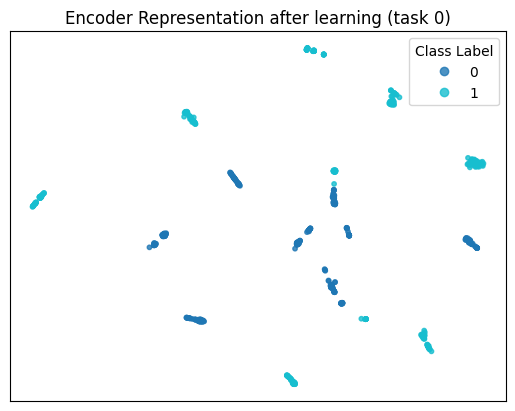

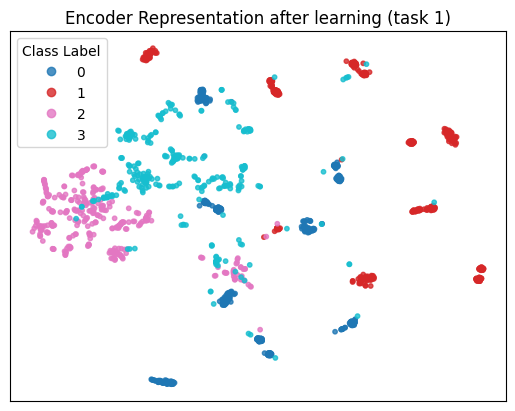

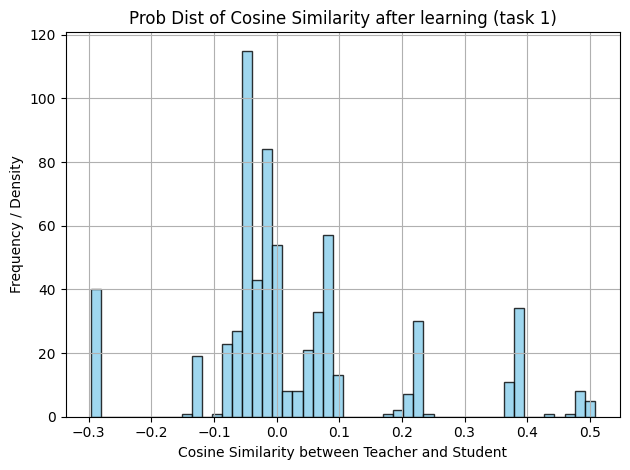

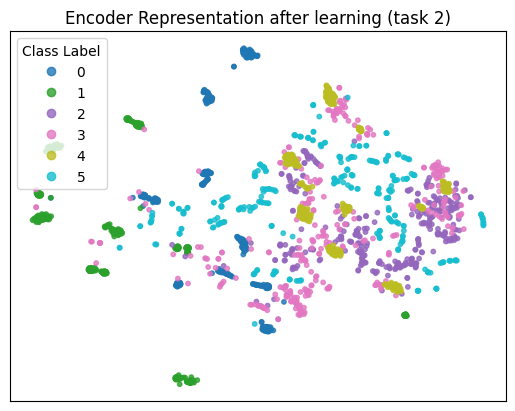

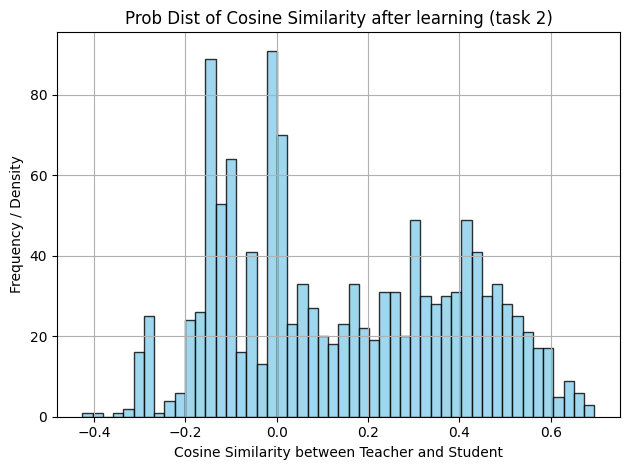

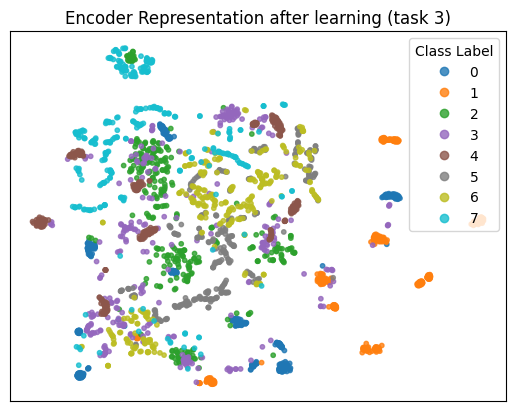

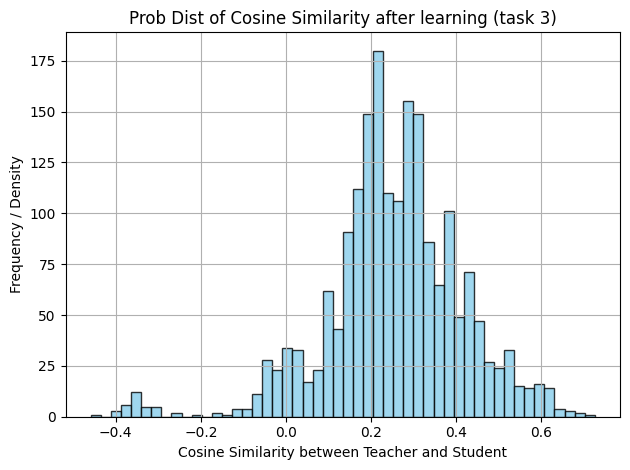

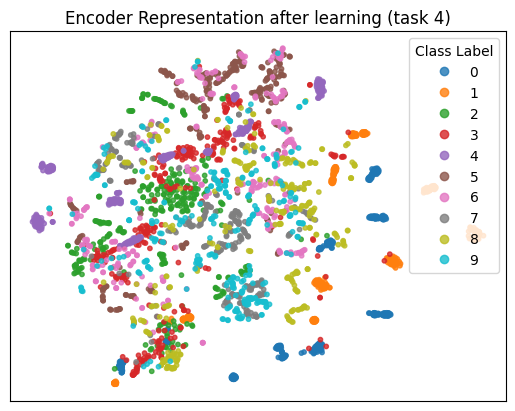

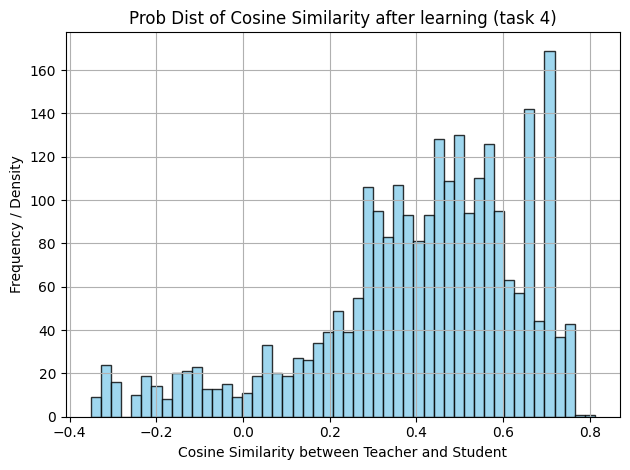

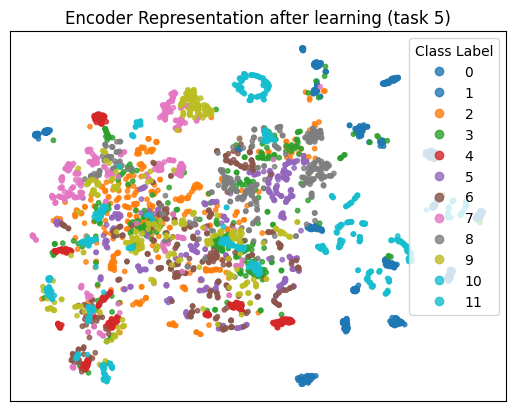

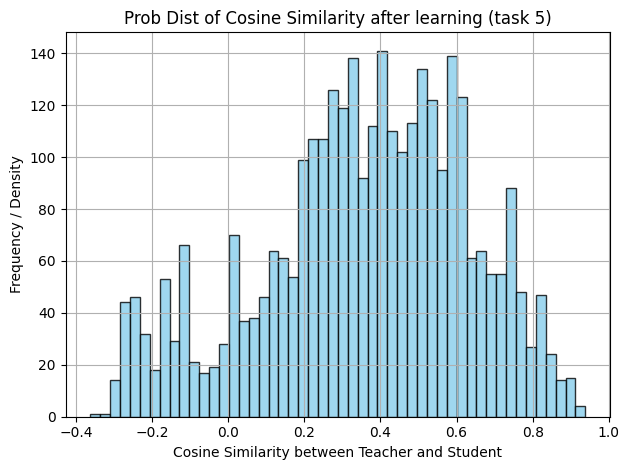

In [12]:
seed_fixer(seed + run)

x_tcurr, y_tcurr = None, None
x_tprev, y_tprev = None, None

for task in range(task_stream.n_tasks):
    (x_i, y_i), _, _ = task_stream.tasks[task]

    if task == 0:
        x_tcurr, y_tcurr = x_i, y_i
    else:
        x_tprev, y_tprev = x_tcurr.copy(), y_tcurr.copy()

        x_tcurr = np.concatenate((x_tcurr, x_i))
        y_tcurr = np.concatenate((y_tcurr, y_i))

    if x_tcurr is not None and y_tcurr is not None:
        x_tcurr_, y_tcurr_ = torch.Tensor(x_tcurr).to(device), torch.Tensor(y_tcurr).to(device)
    if x_tprev is not None and y_tprev is not None:
        x_tprev_, y_tprev_ = torch.Tensor(x_tprev).to(device), torch.Tensor(y_tprev).to(device)

    generator = GCVariationalAutoencoderConv(
        seq_len=input_size_match[data][0],
        feat_dim=input_size_match[data][1],
        latent_dim=128,  # 2 for visualization
        hidden_layer_sizes=[64, 128, 256, 512],  # [128, 256]
        device=device,
        fmap=True,
        recon_wt=0.1,
    )

    n_decoder_tcurr = 2*(task+1) 
    ckpt_tcurr = 2*task+1

    for id in range(n_decoder_tcurr):
        generator.create_decoder(id)

    if ckpt_tcurr != 0:
        generator.copy_encoder()

    checkpoint_path = os.getcwd() + f'/result/exp/debug/CNN_dailysports/GCPPv2_B2/generator_ckpt_{ckpt_tcurr}_r0.pt' 
    state_dict = torch.load(checkpoint_path, map_location='cuda')

    generator.load_state_dict(state_dict)

    z_mean_tcurr_, z_log_var_tcurr_, z_tcurr_ = generator.encoder(x_tcurr_.transpose(1, 2))
    features_tcurr = z_mean_tcurr_.cpu().detach().numpy()

    tsne_tcurr = TSNE(n_components=2)
    tsne_tc = tsne_tcurr.fit_transform(features_tcurr)

    # plt.figure(figsize=(8,6))
    scatter_tcurr = plt.scatter(tsne_tc[:, 0], tsne_tc[:, 1], c=y_tcurr, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter_tcurr.legend_elements(), title="Class Label")
    plt.title(f"Encoder Representation after learning (task {task})")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

    if task != 0:
        z_mean_teacher_, z_log_var_teacher_, z_teacher_ = generator.encoder_teacher(x_tprev_.transpose(1, 2))
        features_teacher = z_mean_teacher_.cpu().detach().numpy()

        tsne_teacher = TSNE(n_components=2)
        tsne_t = tsne_teacher.fit_transform(features_teacher)

        z_mean_student_, z_log_var_student_, z_student_ = generator.encoder(x_tprev_.transpose(1, 2))
        features_student = z_mean_student_.cpu().detach().numpy()

        tsne_student = TSNE(n_components=2)
        tsne_s = tsne_student.fit_transform(features_student)

        z_norm_teacher_ = F.normalize(z_mean_teacher_, dim=1)
        z_norm_student_ = F.normalize(z_mean_student_, dim=1)

        cos_sim = torch.sum(z_norm_teacher_ * z_norm_student_, dim=1)
        cos_sim_np = cos_sim.cpu().detach().numpy()

        plt.hist(cos_sim_np, bins=50, color='skyblue', edgecolor='black', alpha=0.8)
        plt.xlabel('Cosine Similarity between Teacher and Student')
        plt.ylabel('Frequency / Density')
        plt.title(f'Prob Dist of Cosine Similarity after learning (task {task})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()